In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [99]:
# 读取数据
data = pd.read_excel('./data/original_data.xls')
print("初始形状: ",data.shape)


初始形状:  (18840, 12)


## 查看和分析原始数据

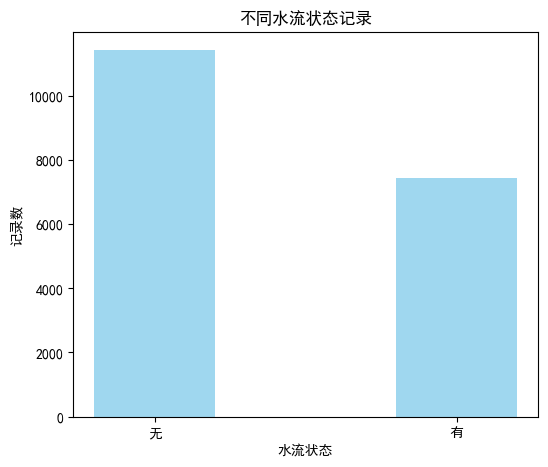

In [100]:
# 有无水流的分布图
flow_yes = pd.value_counts(data['有无水流'])['无']
flow_no = pd.value_counts(data['有无水流'])['有']

fig = plt.figure(figsize=(6,5))
plt.bar(range(2),height=[flow_yes,flow_no],width=0.4,alpha=0.8,color='skyblue')
plt.xticks([index for index in range(2)],['无','有'])
plt.xlabel(u'水流状态')
plt.ylabel(u'记录数')
plt.title(u'不同水流状态记录')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()

## 数据规约

In [101]:
#删除冗余属性，热水器编号，有无水流，节能模式
data.drop(labels=['热水器编号','有无水流','节能模式'],axis=1,inplace=True)
print('删除冗余数据后的数据形状：',data.shape)
data.to_csv('./water_heart.csv',index=False,encoding='utf_8_sig')

删除冗余数据后的数据形状： (18840, 9)


## 用水事件阈值寻优模型

## 划分用水事件

### “用水停顿时间间隔”定义为一条水流量不为0的流水记录同下一条水流量不为0的流水记录之间的时间间隔。
### 两个记录之间超过阈值T则划分为一个用水事件

**一次完整用水事件的划分步骤如下:**
1. 读取数据记录，识别到第一条水流量不为0的数据记录记为R1，按顺序识别接下来的一条水流量不为0的数据记录R2
2. 若两个记录间隔>T，则Ri+1与Ri及之间的数据记录不能划分到同一次用水事件。同时将Ri+1记录作为新的读取数据记录的开始，返回步骤1）；若两个记录间隔<T，则将R_{i+1}与R_i及之间的数据记录划分到同一次用水事件，并记录接下来的水流了不为0数据记录为
3. 循环执行步骤2），直到数据记录读取完毕，结束事件划分。

> 不同地区、不同人、不同季节用水习惯不相同，停顿时长不相同导致阈值差异，建立阈值寻优模型来更新寻找最优的阈值，将事件划分更加合理

In [103]:
# 转换时间格式
data['发生时间'] = pd.to_datetime(data['发生时间'],format='%Y%m%d%H%M%S')
# 保存流量大于0的记录
data = data[data['水流量'] > 0]
print(data)
#输入划分时间的时间阈值，得到划分的事件数
def event_num(ts):
    d = data['发生时间'].diff()>ts
    return d.sum()+1

dt = [pd.Timedelta(minutes=i) for i in np.arange(1,9,0.25)]
h = pd.DataFrame(dt,columns=['阈值'])

# 计算每个阈值对应的事件数
h['事件数'] = h['阈值'].apply(event_num)

# 计算每两个相邻点对应的斜率
h['斜率'] = h['事件数'].diff()/0.25

# 往前取n个斜率绝对值平均作为斜率指标
h['斜率指标']= h['斜率'].abs().rolling(4).mean() 

# 用idxmin返回最小值的Index，由于rolling_mean()计算的是前n个斜率的绝对值平均,所以结果要进行平移（-n）
ts = h['阈值'][h['斜率指标'].idxmin()-4]

if ts > threshold:
    ts = pd.Timedelta(minutes=4)

print('计算出的单次用水时长的阈值为：',ts)

                     发生时间 开关机状态 加热中 保温中  实际温度  热水量  水流量 加热剩余时间 当前设置温度
2     2014-10-19 07:01:56     关   关   关  30°C   0%    8    0分钟   50°C
56    2014-10-19 07:38:16     关   关   关  30°C   0%    8    0分钟   50°C
381   2014-10-19 09:46:38     关   关   关  29°C   0%   16    0分钟   50°C
382   2014-10-19 09:46:40     关   关   关  29°C   0%   13    0分钟   50°C
384   2014-10-19 09:47:15     关   关   关  29°C   0%   20    0分钟   50°C
...                   ...   ...  ..  ..   ...  ...  ...    ...    ...
18742 2014-11-10 22:00:38     开   开   关  37°C  25%   26   17分钟   50°C
18743 2014-11-10 22:00:42     开   开   关  37°C  25%   23   17分钟   50°C
18744 2014-11-10 22:00:46     开   开   关  37°C  25%   25   17分钟   50°C
18798 2014-11-10 22:19:43     开   关   开  50°C  50%    8    0分钟   50°C
18800 2014-11-10 22:49:07     开   关   开  50°C  50%    8    0分钟   50°C

[7696 rows x 9 columns]
计算出的单次用水时长的阈值为： 0 days 00:04:00


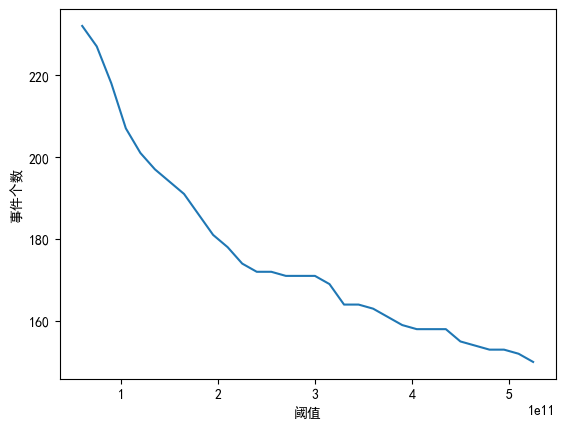

In [104]:
plt.plot(h['阈值'],h['事件数'])
plt.xlabel(u'阈值')
plt.ylabel(u'事件个数')
plt.show()

In [105]:
# 阈值为4分钟
threshold = pd.Timedelta('4 min')
# 相邻时间向前差分，比较是否大于阈值 diff():df-df.shift()
sjKs = data['发生时间'].diff() > threshold

# 令第一个时间为第一个用水事件的开始事件
sjKs.iloc[0] = True
sjJs = sjKs.iloc[1:]  # 向后差分的结果
sjJs = pd.concat([sjJs,pd.Series(True)])  # 令最后一个时间作为最后一个用水事件的结束时间

# 创建数据框，并定义用水事件序列
sj = pd.DataFrame(np.arange(1,sum(sjKs)+1),columns = ["事件序号"])
sj["事件起始编号"] = data.index[sjKs == 1]+1  # 定义用水事件的起始编号
sj["事件终止编号"] = data.index[sjJs == 1]+1  # 定义用水事件的终止编号
print('当阈值为4分钟的时候事件数目为：',sj.shape[0])
sj.to_csv('./sj.csv',index = False,encoding='utf_8_sig')

当阈值为4分钟的时候事件数目为： 172


## 属性构造

1. 时长指标
| 指标      | 构建方法 | 
| ----------- | ----------- |
| 用水开始时间  | 用水开始时间=起始数据的时间一发送阈值/2 |
| 用水结束时间   | 用水结束时间=结束数据的时间＋发送阈值/2 |
| 用水时长      | 一次完整用水事件中，对水流量不为0的数据做计算 |
| 总用水时长   | 从划分出的用水事件,起始数据的时间到终止数据的时间间隔+发送阈值 |
| 用水时长/总用水时长      | 用水时长与总用水时长的比值|
| 停顿时长   | 一次完整用水事件中，对水流量为0的数据做计算 |
| 总停顿时长      | 一次完整用水事件中的所有停顿时长之和 |
| 平均停顿时长   | 一次完整用水事件中的所有停顿时长的平均值 |


2. 频率指标
| 指标      | 构建方法 | 
| ----------- | ----------- |
| 停顿次数  |一次完成用水事件中关掉热水的次数之和 |

3. 用水量指标
| 指标      | 构建方法 | 
| ----------- | ----------- |
| 总用水量  | 总用水量=每条有水流数据的用水量=持续时间*水流大小 |
|平均水流量 | 平均水流量=总用水量/有水流时间 |

4. 用水波动指标
| 指标      | 构建方法 | 
| ----------- | ----------- |
| 水流量波动  | 水流量波动=∑((单次用水量 - 平均水流量 ) ^ 2 * 持续时间 ) / 总的有水流量时间 |
| 停顿时长波动 | 停顿时长波动=∑((单次停顿时长 - 平均停顿时长 ) ^ 2 * 持续时间 ) / 总停顿时长 |

In [106]:
data = pd.read_csv('./water_heart.csv')
# 读取用水事件记录
sj = pd.read_csv('./sj.csv')
# 转换时间格式
data["发生时间"] = pd.to_datetime(data["发生时间"],format="%Y%m%d%H%M%S")

# 构造特征：总用水时长
timeDel = pd.Timedelta("0.5 sec")
sj["事件开始时间"] = data.iloc[sj["事件起始编号"]-1,0].values- timeDel
sj["事件结束时间"] = data.iloc[sj["事件终止编号"]-1,0].values + timeDel
sj['洗浴时间点'] = [i.hour for i in sj["事件开始时间"]]
sj["总用水时长"] = np.int64(sj["事件结束时间"] - sj["事件开始时间"])/1000000000 + 1

# 构造用水停顿事件
# 构造特征“停顿开始时间”、“停顿结束时间”
# 停顿开始时间指从有水流到无水流，停顿结束时间指从无水流到有水流
for i in range(len(data)-1):
    if (data.loc[i,"水流量"] != 0) & (data.loc[i + 1,"水流量"] == 0) :
        data.loc[i + 1,"停顿开始时间"] = data.loc[i +1, "发生时间"] - timeDel
    if (data.loc[i,"水流量"] == 0) & (data.loc[i + 1,"水流量"] != 0) :
        data.loc[i,"停顿结束时间"] = data.loc[i , "发生时间"] + timeDel
        
# 提取停顿开始时间与结束时间所对应行号，放在数据框Stop中
indStopStart = data.index[data["停顿开始时间"].notnull()]+1
indStopEnd = data.index[data["停顿结束时间"].notnull()]+1
Stop = pd.DataFrame(data={"停顿开始编号":indStopStart[:-1],
                            "停顿结束编号":indStopEnd[1:]}) 
# 计算停顿时长，并放在数据框stop中，停顿时长=停顿结束时间-停顿结束时间
Stop["停顿时长"] = np.int64(data.loc[indStopEnd[1:]-1,"停顿结束时间"].values-
                     data.loc[indStopStart[:-1]-1,"停顿开始时间"].values)/1000000000
# 将每次停顿与事件匹配,停顿的开始时间要大于事件的开始时间，
# 且停顿的结束时间要小于事件的结束时间
for i in range(len(sj)):
    Stop.loc[(Stop["停顿开始编号"] > sj.loc[i,"事件起始编号"]) & 
           (Stop["停顿结束编号"] < sj.loc[i,"事件终止编号"]),"停顿归属事件"]=i+1
             
# 删除停顿次数为0的事件
Stop = Stop[Stop["停顿归属事件"].notnull()]

# 构造特征 用水事件停顿总时长、停顿次数、停顿平均时长、
# 用水时长，用水/总时长
stopAgg =  Stop.groupby("停顿归属事件").agg({"停顿时长":sum,"停顿开始编号":len})
sj.loc[stopAgg.index - 1,"总停顿时长"] = stopAgg.loc[:,"停顿时长"].values
sj.loc[stopAgg.index-1,"停顿次数"] = stopAgg.loc[:,"停顿开始编号"].values
sj.fillna(0,inplace=True)  # 对缺失值用0插补
stopNo0 = sj["停顿次数"] != 0  # 判断用水事件是否存在停顿
sj.loc[stopNo0,"平均停顿时长"] = sj.loc[stopNo0,"总停顿时长"]/sj.loc[stopNo0,"停顿次数"] 
sj.fillna(0,inplace=True)  # 对缺失值用0插补
sj["用水时长"] = sj["总用水时长"] - sj["总停顿时长"]  # 定义特征用水时长
sj["用水/总时长"] = sj["用水时长"] / sj["总用水时长"]  # 定义特征 用水/总时长

data["水流量"] = data["水流量"] / 60 # 原单位L/min，现转换为L/sec
sj["总用水量"] = 0 # 给总用水量赋一个初始值0
for i in range(len(sj)):
    Start = sj.loc[i,"事件起始编号"]-1
    End = sj.loc[i,"事件终止编号"]-1
    if Start != End:
        for j in range(Start,End):
            if data.loc[j,"水流量"] != 0:
                sj.loc[i,"总用水量"] = (data.loc[j + 1,"发生时间"] - 
                                    data.loc[j,"发生时间"]).seconds* \
                                    data.loc[j,"水流量"] + sj.loc[i,"总用水量"]
        sj.loc[i,"总用水量"] = sj.loc[i,"总用水量"] + data.loc[End,"水流量"] * 2
    else:
        sj.loc[i,"总用水量"] = data.loc[Start,"水流量"] * 2
        
sj["平均水流量"] = sj["总用水量"] / sj["用水时长"] # 定义特征 平均水流量
# 构造特征：水流量波动
# 水流量波动=∑(((单次水流的值-平均水流量)^2)*持续时间)/用水时长
sj["水流量波动"] = 0 # 给水流量波动赋一个初始值0
for i in range(len(sj)):
    Start = sj.loc[i,"事件起始编号"] - 1
    End = sj.loc[i,"事件终止编号"] - 1
    for j in range(Start,End + 1):
        if data.loc[j,"水流量"] != 0:
            slbd = (data.loc[j,"水流量"] - sj.loc[i,"平均水流量"])**2
            slsj = (data.loc[j + 1,"发生时间"] - data.loc[j,"发生时间"]).seconds
            sj.loc[i,"水流量波动"] = slbd * slsj + sj.loc[i,"水流量波动"]
    sj.loc[i,"水流量波动"] = sj.loc[i,"水流量波动"] / sj.loc[i,"用水时长"]   

# 构造特征：停顿时长波动
# 停顿时长波动=∑(((单次停顿时长-平均停顿时长)^2)*持续时间)/总停顿时长
sj["停顿时长波动"] = 0 # 给停顿时长波动赋一个初始值0
for i in range(len(sj)):
    if sj.loc[i,"停顿次数"] > 1: # 当停顿次数为0或1时，停顿时长波动值为0，故排除
        for j in Stop.loc[Stop["停顿归属事件"] == (i+1),"停顿时长"].values:
            sj.loc[i,"停顿时长波动"] = ((j - sj.loc[i,"平均停顿时长"])**2) * j + \
                                     sj.loc[i,"停顿时长波动"]
        sj.loc[i,"停顿时长波动"] = sj.loc[i,"停顿时长波动"] / sj.loc[i,"总停顿时长"]

print('用水量和波动特征构造完成后数据的特征为：\n',sj.columns)

用水量和波动特征构造完成后数据的特征为：
 Index(['事件序号', '事件起始编号', '事件终止编号', '事件开始时间', '事件结束时间', '洗浴时间点', '总用水时长',
       '总停顿时长', '停顿次数', '平均停顿时长', '用水时长', '用水/总时长', '总用水量', '平均水流量', '水流量波动',
       '停顿时长波动'],
      dtype='object')


## 筛选得到候选洗浴事件
1. 用水时长>100
2. 总用水时长>120
3. 总用水量>5L

In [107]:
sj_bool = (sj['用水时长'] >100) & (sj['总用水时长'] > 120) & (sj['总用水量'] > 5)
sj_final = sj.loc[sj_bool,:]
sj_final.to_csv('./sj_final.csv',index=False,encoding='utf_8_sig')
print('筛选出候选洗浴事件前的数据形状为：',sj.shape)
print('筛选出候选洗浴事件后的数据形状为：',sj_final.shape)

筛选出候选洗浴事件前的数据形状为： (172, 16)
筛选出候选洗浴事件后的数据形状为： (75, 16)


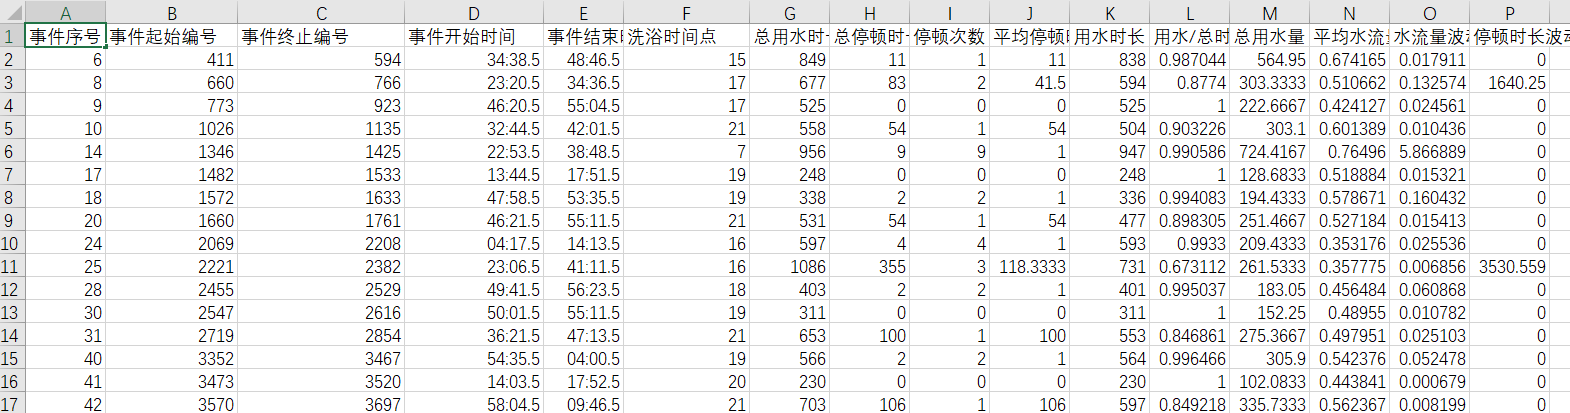

## 模型训练

### sklearn 的 MLPClassifier
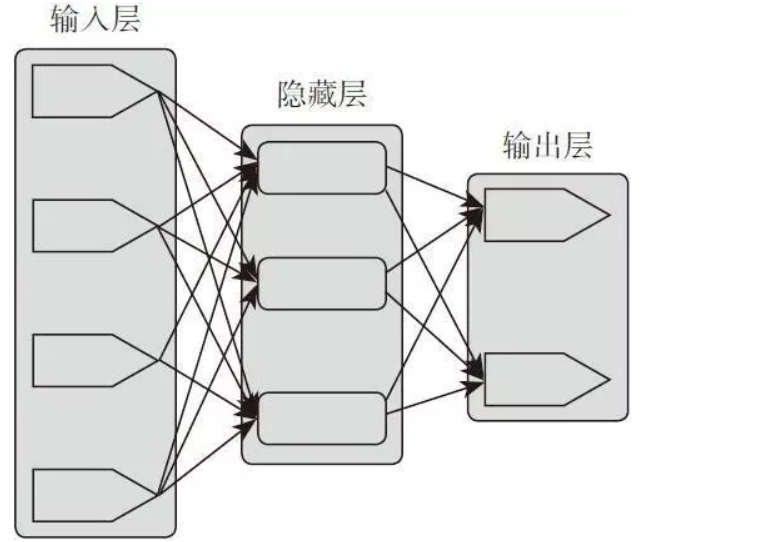

In [108]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# 读取数据
Xtrain = pd.read_csv('./sj_final.csv')
ytrain = pd.read_excel('data/water_heater_log.xlsx')
test = pd.read_excel('data/test_data.xlsx')
# 训练集测试集区分
x_train, x_test, y_train, y_test = Xtrain.iloc[:,5:],test.iloc[:,4:-1],\
                                   ytrain.iloc[:,-1],test.iloc[:,-1]
# 标准化
stdScaler = StandardScaler().fit(x_train)
x_stdtrain = stdScaler.transform(x_train)
x_stdtest = stdScaler.transform(x_test)
# 建立模型
bpnn = MLPClassifier(hidden_layer_sizes = (17,10), max_iter = 200, solver = 'lbfgs',random_state=50)
bpnn.fit(x_stdtrain, y_train)
# 保存模型
joblib.dump(bpnn,'./water_heater_nnet.m')
print('构建的模型为：\n',bpnn)

构建的模型为：
 MLPClassifier(hidden_layer_sizes=(17, 10), random_state=50, solver='lbfgs')


In [109]:
# 模型评价
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import joblib
import matplotlib.pyplot as plt

bpnn = joblib.load('./water_heater_nnet.m')  # 加载模型
y_pred = bpnn.predict(x_stdtest)  # 返回预测结果
print('神经网络预测结果评价报告：\n',classification_report(y_test,y_pred))

神经网络预测结果评价报告：
               precision    recall  f1-score   support

           0       0.47      0.75      0.58        12
           1       0.90      0.73      0.81        37

    accuracy                           0.73        49
   macro avg       0.69      0.74      0.69        49
weighted avg       0.80      0.73      0.75        49



In [110]:
t = y_test.to_list()
p = y_pred.tolist()
alllen = len(t)
yescount = 0
for i in range(alllen):
    print(t[i],p[i],'yes' if t[i] == p[i] else 'no')
    if t[i] == p[i]:
        yescount = yescount+1
print(yescount,'/',alllen)

1 1 yes
1 1 yes
1 1 yes
0 0 yes
1 1 yes
0 0 yes
0 0 yes
0 0 yes
1 1 yes
0 1 no
1 1 yes
1 1 yes
1 1 yes
1 1 yes
1 1 yes
0 0 yes
1 0 no
0 0 yes
0 1 no
1 1 yes
1 0 no
1 1 yes
1 1 yes
1 1 yes
1 0 no
1 1 yes
1 0 no
1 0 no
1 1 yes
1 1 yes
0 0 yes
1 0 no
0 0 yes
1 1 yes
0 1 no
1 1 yes
1 0 no
1 1 yes
1 1 yes
1 1 yes
1 0 no
1 1 yes
1 0 no
1 0 no
1 1 yes
1 1 yes
0 0 yes
1 1 yes
1 1 yes
36 / 49
